In [1]:
import os
import gc
import csv
import sys
import ast
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing, cross_validation, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,accuracy_score
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve

from imblearn.over_sampling import SMOTE

csv.field_size_limit(sys.maxsize)
os.chdir('../Data/Seattle/')

/Users/minjiazhu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/minjiazhu/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Data Cleaning Helper Function

In [57]:
def sublist_uniques(df,sublist):
    '''
    https://stackoverflow.com/questions/36487842/python-pandas-how-to-create-a-binary-matrix-from-column-of-lists
    '''
    categories = set()
    for d,t in df.iterrows():
        try:
            for j in ast.literal_eval(t[sublist]):
                categories.add(j)
        except:
            pass
    return list(categories)


def sublists_to_dummies(df,sublist,index_key = None):
    '''
    Create a binary matrix from column of lists
    Sample usage: sublists_to_dummies(df,'cuisines')
                  sublists_to_dummies(a,'labels','group') - Aggregate by group

    '''
    categories = sublist_uniques(df,sublist)
    df_output = pd.DataFrame(columns=categories)
    for d,i in df.iterrows():
        sub_lst = ast.literal_eval(i[sublist])
        if type(sub_lst) == list or np.array:
            try:
                if index_key != None:
                    key = i[index_key]
                    f =np.zeros(len(categories))
                    for j in sub_lst:
                        f[categories.index(j)] = 1
                    if key in  df_output.index:
                        for j in sub_lst:
                             df_output.loc[key][j]+=1
                    else:
                         df_output.loc[key]=f
                else:
                    f =np.zeros(len(categories))
                    for j in sub_lst:
                        f[categories.index(j)] = 1
                    df_output.loc[d]=f
            except:
                pass

    return df_output


def data_clean():
    '''
    Basic Data Cleaning for 'seattle_instances_mergerd.csv'
    '''
    df = pd.read_csv('seattle_instances_mergerd.csv', sep=None,engine='python')
    # Convert to datetime object
    df.inspection_period_start_date = pd.to_datetime(df.inspection_period_start_date)
    df.inspection_period_end_date = pd.to_datetime(df.inspection_period_end_date)

    # Remove inpection_score = -1 outlier
    df = df[df.inspection_penalty_score >= 0]
    
    # Convert zip code to categorical variable of disrict 
    df["zip_code"] = df["zip_code"].astype('category')

    # Create a dummy  variable for cuisions types 
    df_c = sublists_to_dummies(df,'cuisines')
    
    df_final = pd.concat([df, df_c], axis=1, join_axes=[df.index])
    
    df_final.to_csv('seattle_instances_mergerd_cleaned.csv')
    return df_final

In [58]:
df = data_clean()

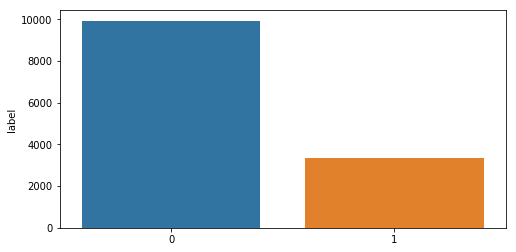

In [85]:
fig = plt.figure(figsize=(8,4))
sns.barplot(x = df['label'].unique(), y=df['label'].value_counts())
plt.show()

In [83]:
X.head()

zip_code  review_count  non_positive_review_count  average_review_rating  \
0     98116             1                          0               5.000000   
1     98116             3                          0               4.000000   
2     98116             7                          0               4.428571   
3     98116             3                          1               3.333333   
4     98116             4                          2               3.250000   

   Vegan  Cheesesteaks  Asian Fusion  Persian/Iranian  Creperies  Turkish  \
0    0.0           0.0           0.0              0.0        0.0      0.0   
1    0.0           0.0           0.0              0.0        0.0      0.0   
2    0.0           0.0           0.0              0.0        0.0      0.0   
3    0.0           0.0           0.0              0.0        0.0      0.0   
4    0.0           0.0           0.0              0.0        0.0      0.0   

      ...      Fondue  Restaurants  Irish  Egyptian  Mediterranean  Burgers  \
0     ...         0.0          1.0    0.0       0.0            0.0      0.0   
1     ...         0.0          1.0    0.0       0.0            0.0      0.0   
2     ...         0.0          1.0    0.0       0.0            0.0      0.0   
3     ...         0.0          1.0    0.0       0.0            0.0      0.0   
4     ...         0.0          1.0    0.0       0.0            0.0      0.0   

   Venezuelan  Breakfast & Brunch  Hot Dogs  Vegetarian  
0         0.0                 0.0       0.0         0.0  
1         0.0                 0.0       0.0         0.0  
2         0.0                 0.0       0.0         0.0  
3         0.0                 0.0       0.0         0.0  
4         0.0                 0.0       0.0         0.0  

[5 rows x 103 columns]

## ML pipline Helper function

In [21]:
# Code modified from https://github.com/rayidghani/magicloops

def define_clfs_params(grid_size):
    """Define defaults for different classifiers.
    Define three types of grids:
    Test: for testing your code
    Small: small grid
    Large: Larger grid that has a lot more parameter sweeps
    """

    clfs = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
        'ET': ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='entropy'),
        'AB': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
        'LR': LogisticRegression(penalty='l1', C=1e5),
        'SVM': svm.SVC(kernel='linear', probability=True, random_state=0),
        'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
        'NB': GaussianNB(),
        'DT': DecisionTreeClassifier(),
        'SGD': SGDClassifier(loss="hinge", penalty="l2"),
        'KNN': KNeighborsClassifier(n_neighbors=3) 
            }

    large_grid = { 
    'RF':{'n_estimators': [1,10,100,1000,10000], 'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.0001,0.001,0.01,0.1,1,10]},
    'SGD': { 'loss': ['hinge','log','perceptron'], 'penalty': ['l2','l1','elasticnet']},
    'ET': { 'n_estimators': [1,10,100,1000,10000], 'criterion' : ['gini', 'entropy'] ,'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10], 'n_jobs': [-1]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [1,10,100,1000,10000], 'learning_rate' : [0.001,0.01,0.05,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [1,3,5,10,20,50,100]},
    'NB' : {},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
           }
    
    small_grid = { 
    'RF':{'n_estimators': [10,100], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.001,0.1,1,10]},
    'SGD': { 'loss': ['hinge','log','perceptron'], 'penalty': ['l2','l1','elasticnet']},
    'ET': { 'n_estimators': [10,100], 'criterion' : ['gini', 'entropy'] ,'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [10,100], 'learning_rate' : [0.001,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [5,50]},
    'NB' : {},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
           }
    
    test_grid = { 
    'RF':{'n_estimators': [1], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'LR': { 'penalty': ['l1'], 'C': [0.01]},
    'SGD': { 'loss': ['perceptron'], 'penalty': ['l2']},
    'ET': { 'n_estimators': [1], 'criterion' : ['gini'] ,'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'AB': { 'algorithm': ['SAMME'], 'n_estimators': [1]},
    'GB': {'n_estimators': [1], 'learning_rate' : [0.1],'subsample' : [0.5], 'max_depth': [1]},
    'NB' : {},
    'DT': {'criterion': ['gini'], 'max_depth': [1],'min_samples_split': [10]},
    'SVM' :{'C' :[0.01],'kernel':['linear']},
    'KNN' :{'n_neighbors': [5],'weights': ['uniform'],'algorithm': ['auto']}
           }
    
    if (grid_size == 'large'):
        return clfs, large_grid
    elif (grid_size == 'small'):
        return clfs, small_grid
    elif (grid_size == 'test'):
        return clfs, test_grid
    else:
        return 0, 0
    
def joint_sort_descending(l1, l2):
    # l1 and l2 have to be numpy arrays
    idx = np.argsort(l1)[::-1]
    return l1[idx], l2[idx]

def generate_binary_at_k(y_scores, k):
    cutoff_index = int(len(y_scores) * (k / 100.0))
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary

def precision_at_k(y_true, y_scores, k):
    y_scores, y_true = joint_sort_descending(np.array(y_scores), np.array(y_true))
    preds_at_k = generate_binary_at_k(y_scores, k)
    precision = precision_score(y_true, preds_at_k)
    return precision

def plot_precision_recall_n(y_true, y_prob, model_name):
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax1.set_ylim([0,1])
    ax1.set_ylim([0,1])
    ax2.set_xlim([0,1])
    
    name = model_name
    plt.title(name)
    #plt.savefig(name)
    plt.show()
    

def clf_loop(df, models_to_run, clfs, grid,threshold_lst,balanced=True):
    """Runs the loop using models_to_run, clfs, gridm and the data
    """
    results_df =  pd.DataFrame(columns=('threshold','model_type','clf', 'parameters', 'MSE','auc-roc','p_at_1','p_at_2','p_at_5', 'p_at_10', 'p_at_20'))
    models = {}
    for threshold in threshold_lst:
        df['label'] = np.where(df['inspection_penalty_score']>=threshold, 1, 0)
        # Define features and laebl 
        y = df.label
        drop_features = ['label','Unnamed: 0','inspection_id', 'restaurant_id', 
                         'inspection_period_start_date','review_contents',
                         'inspection_period_end_date', 'inspection_penalty_score',
                         'cuisines']
        X = df.drop(drop_features, axis=1)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
        # Balance data
        if balanced:
            X_train, y_train = SMOTE().fit_sample(X_train, y_train)
        for index,clf in enumerate([clfs[x] for x in models_to_run]):
            print(models_to_run[index],threshold)
            parameter_values = grid[models_to_run[index]]
            for p in ParameterGrid(parameter_values):
                try:
                    clf.set_params(**p)
                    fitted_model = clf.fit(X_train, y_train)
                    models[str(models_to_run[index])+"--"+str(p)] = fitted_model
                    y_pred_probs = fitted_model.predict_proba(X_test)[:,1]
                    y_pred = fitted_model.predict(X_test)
                    mse = mean_squared_error(y_test, y_pred)
                    
                    y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))
                    results_df.loc[len(results_df)] = [threshold, models_to_run[index],clf, p,mse,
                                                       roc_auc_score(y_test, y_pred_probs),
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,1.0),
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,2.0),
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,5.0),
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,10.0),
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,20.0)]
                    plot_precision_recall_n(y_test,y_pred_probs,clf)
                except IndexError as e:
                    print('Error:',e)
                    continue
                    
    filename = 'ml_results'
    if not balanced:
        filename +="_imbalanced"
    results_df.to_csv(filename +'.csv', index=False)
    return models

In [22]:
# Load dataset
df = pd.read_csv('seattle_instances_mergerd_cleaned.csv', sep=None,engine='python')

LR 5


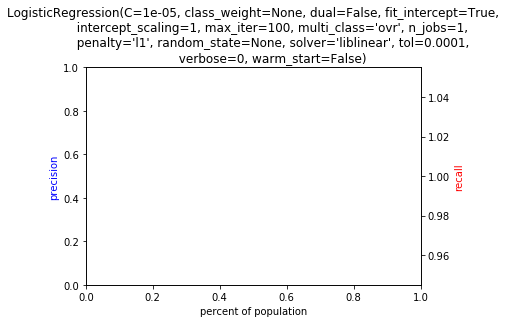

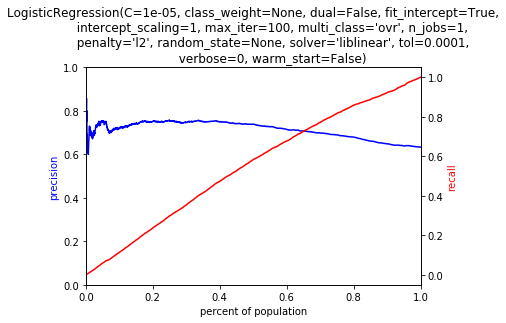

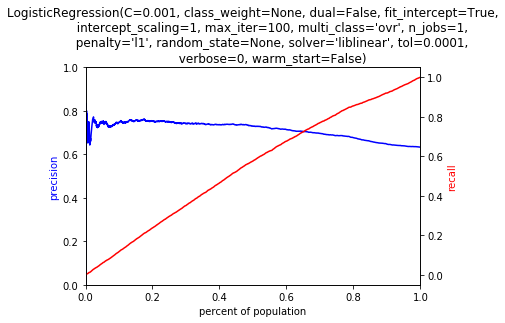

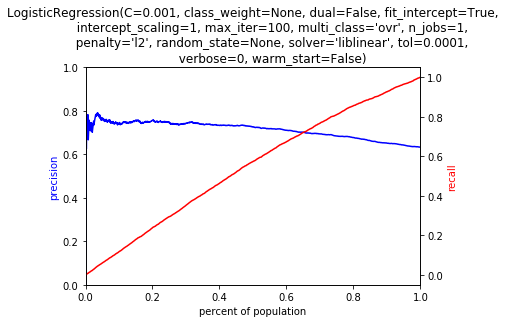

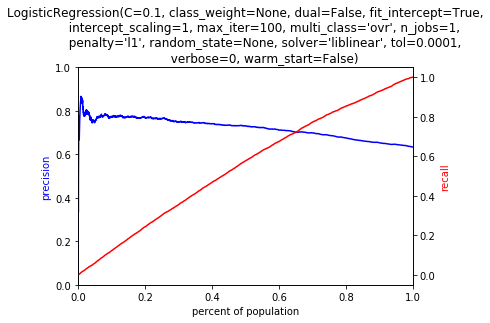

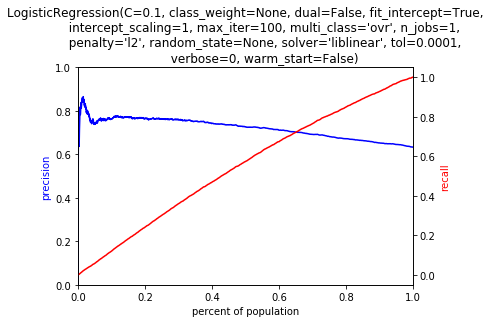

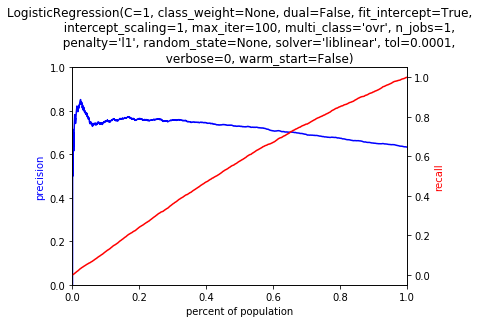

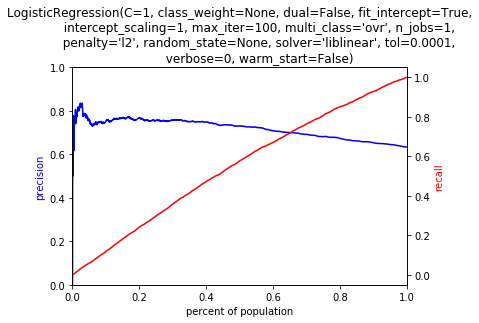

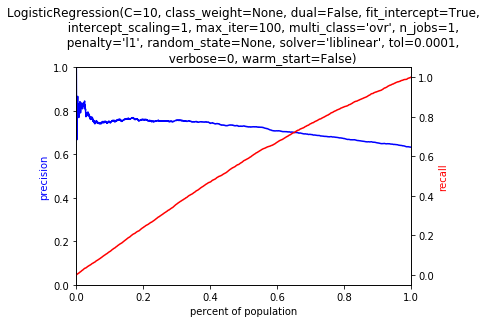

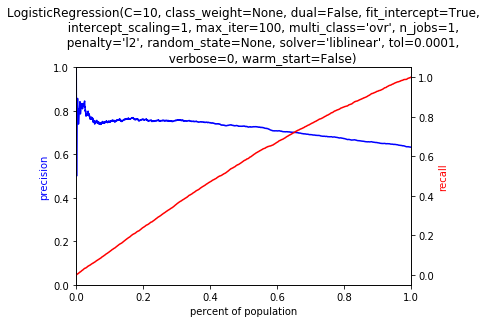

NB 5


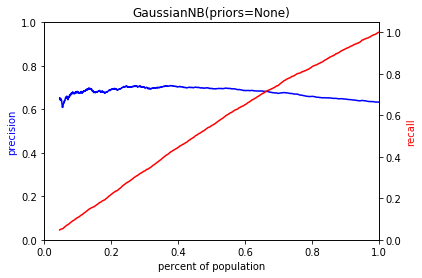

LR 10


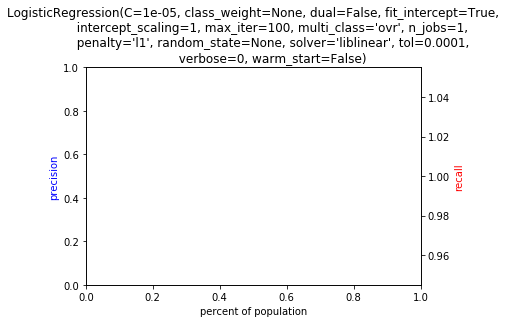

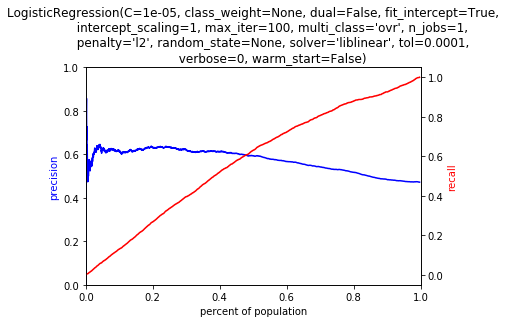

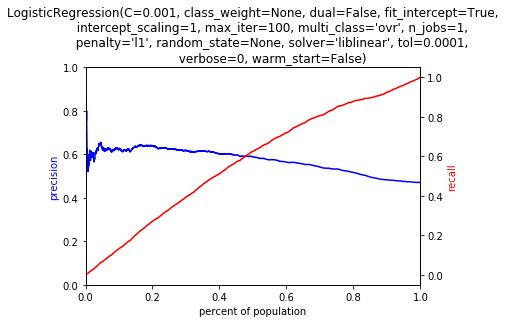

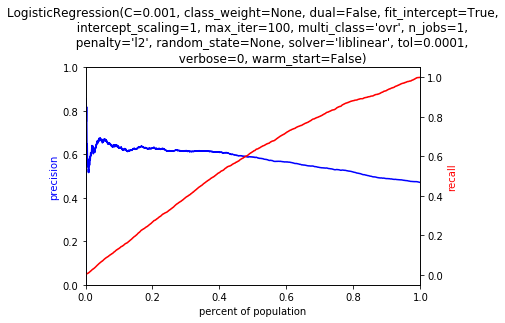

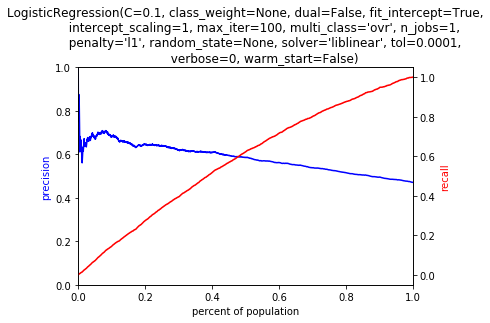

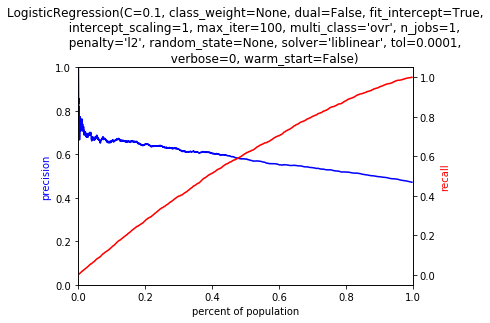

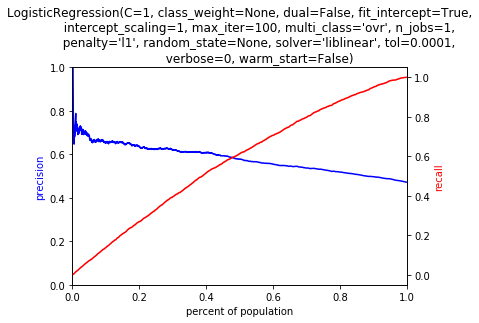

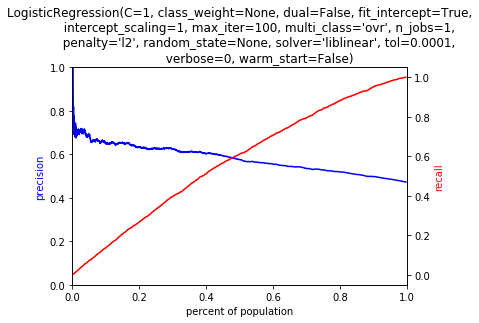

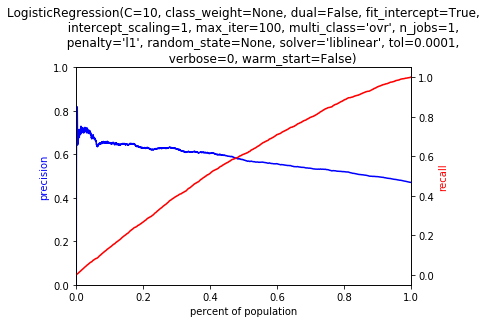

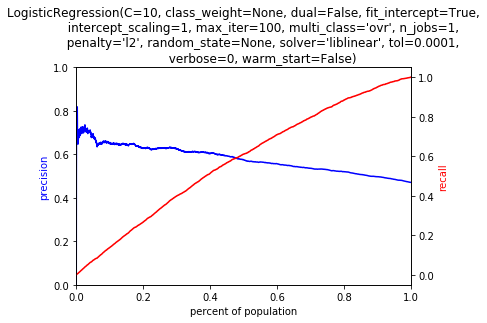

NB 10


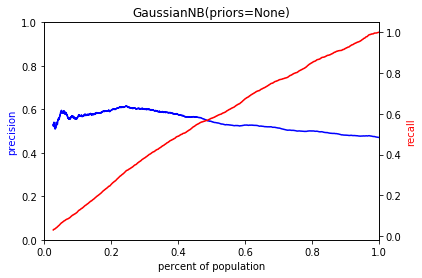

LR 20


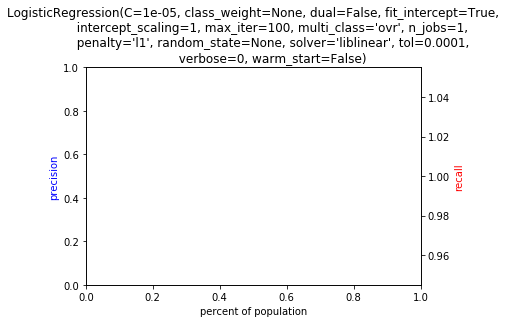

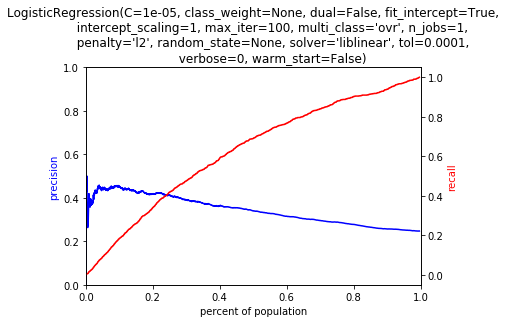

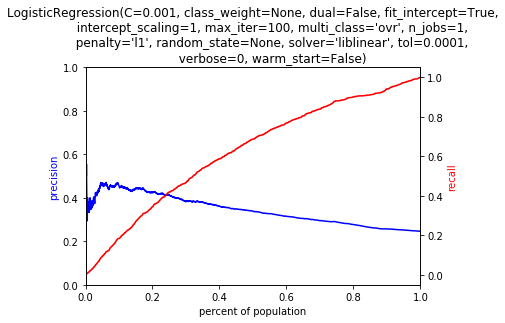

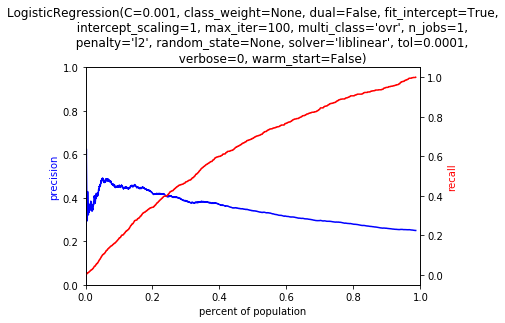

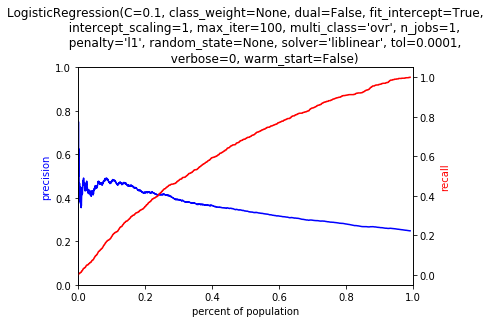

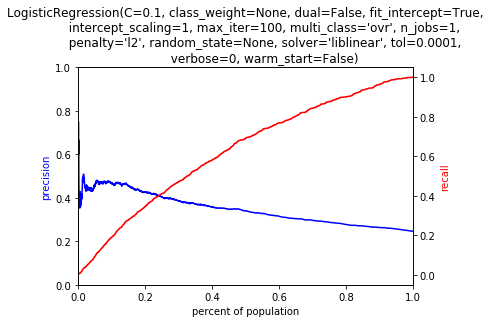

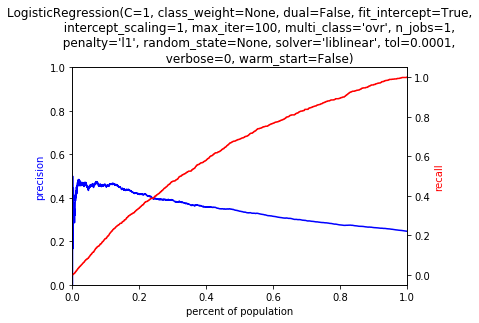

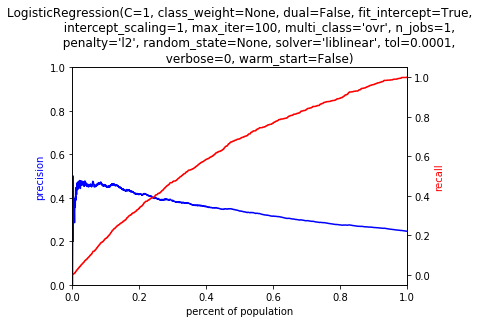

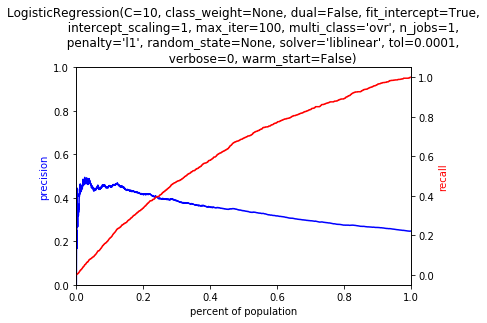

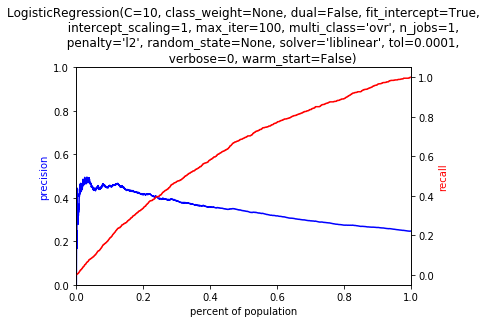

NB 20


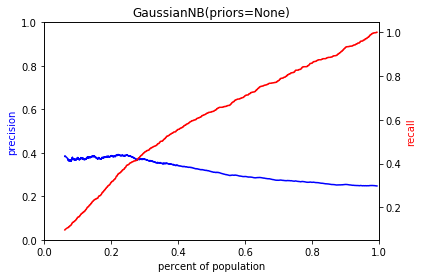

LR 30


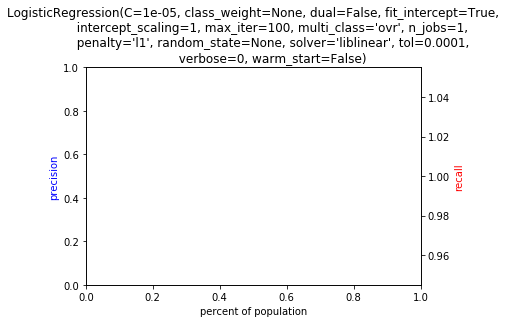

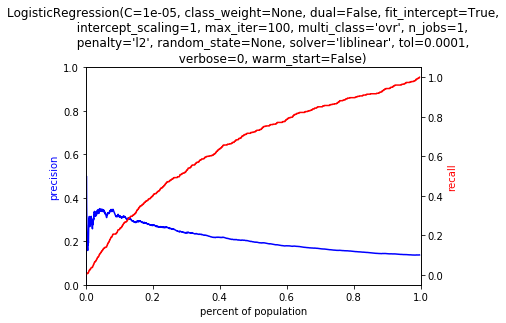

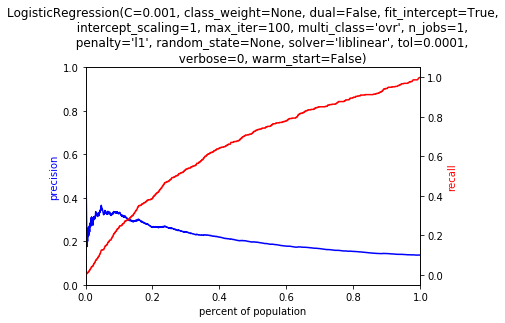

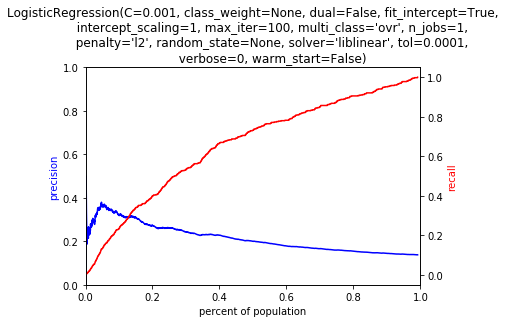

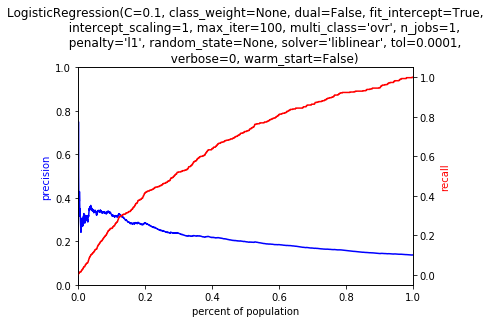

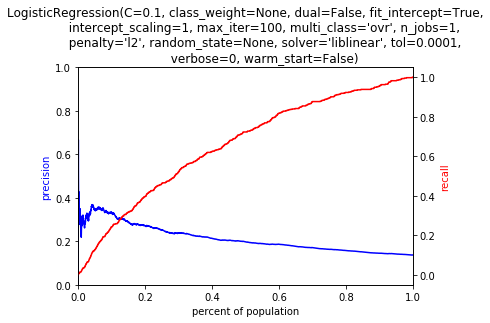

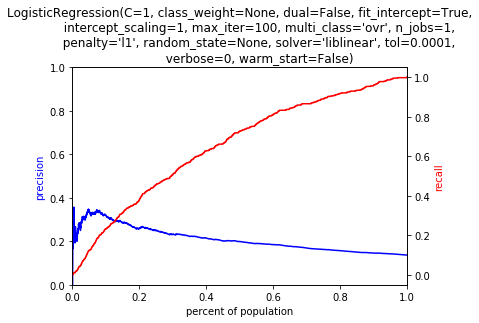

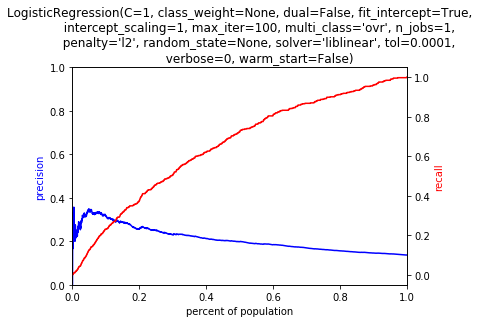

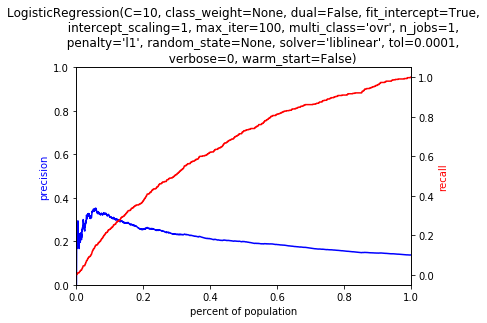

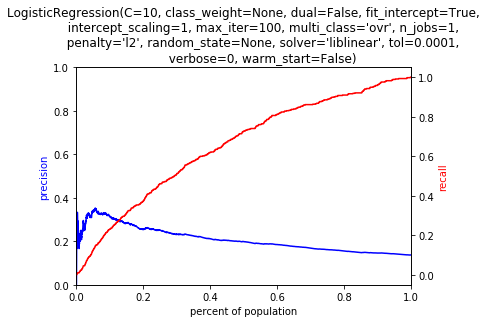

NB 30


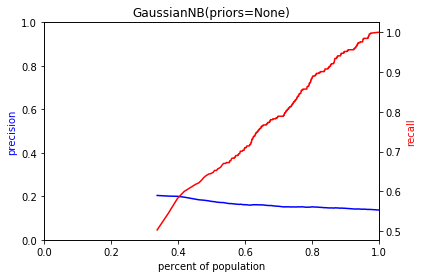

LR 40


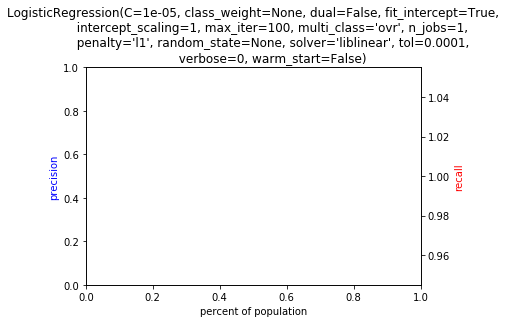

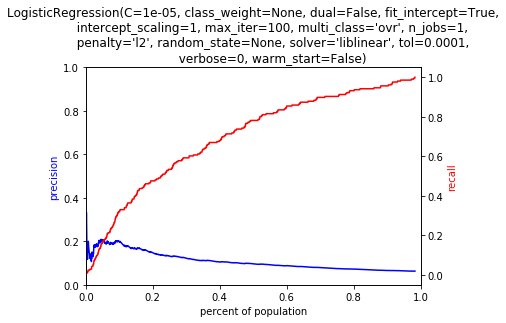

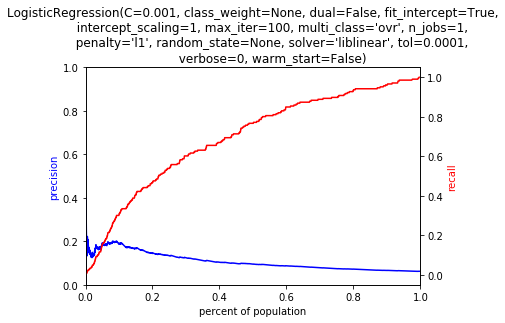

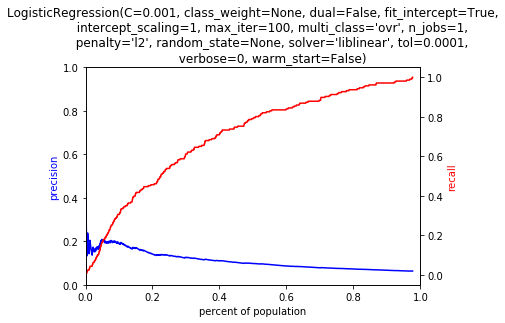

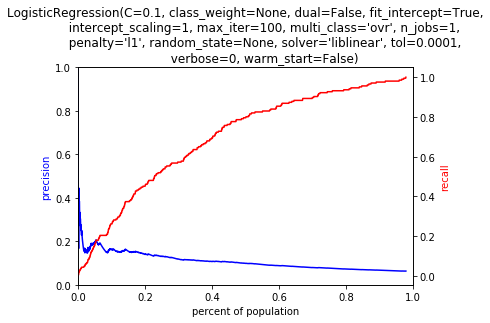

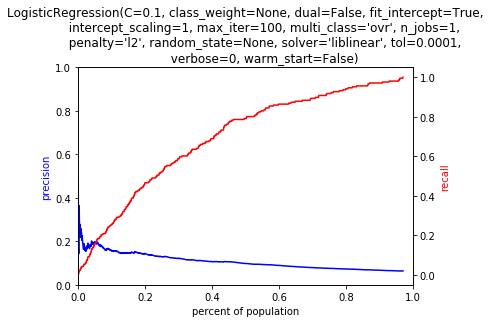

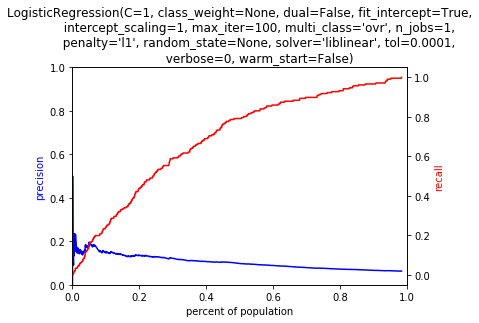

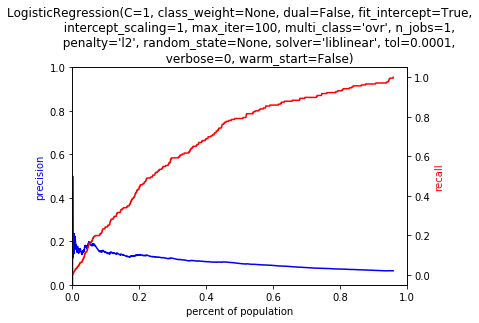

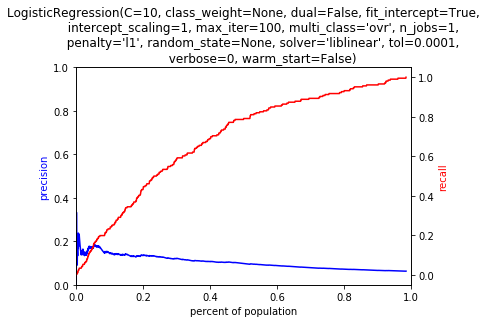

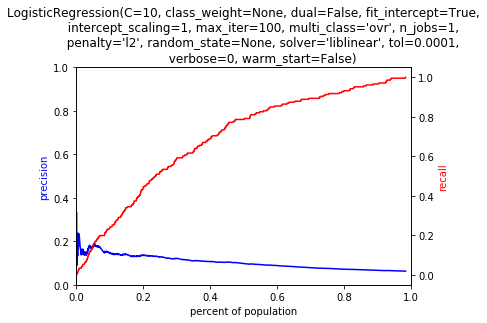

NB 40


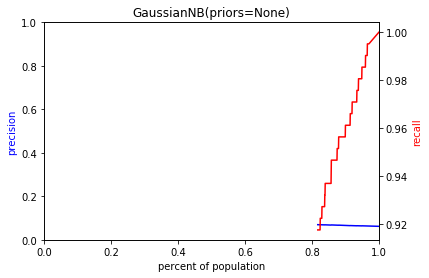

LR 50


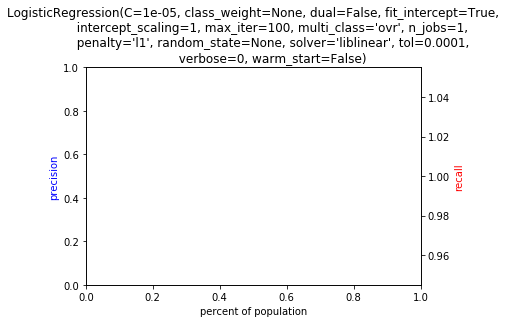

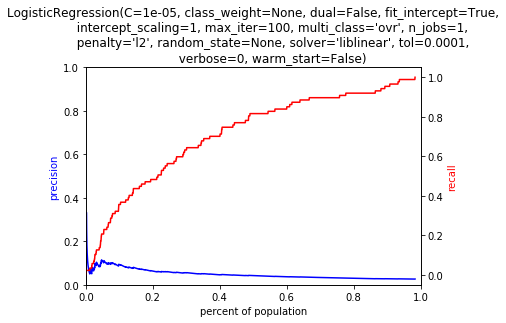

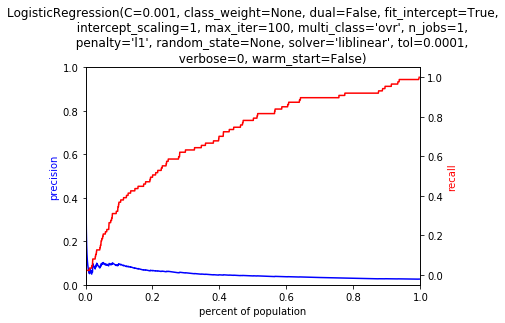

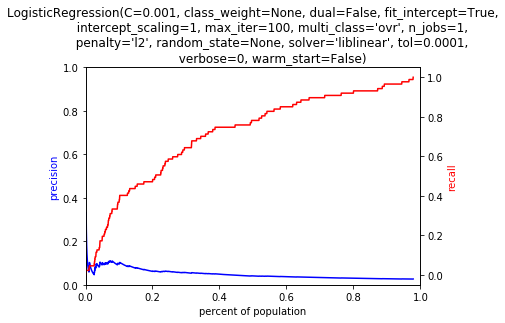

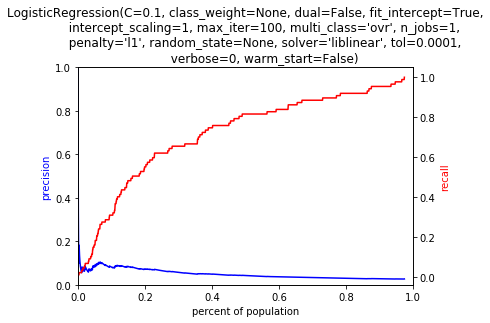

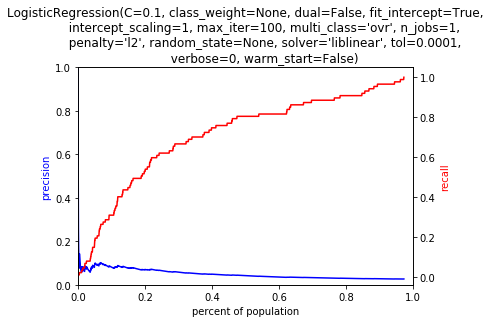

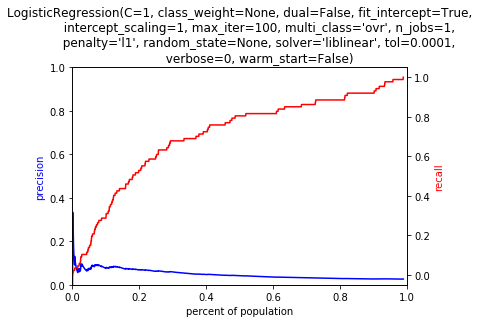

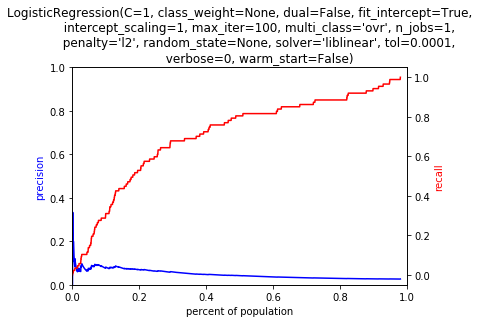

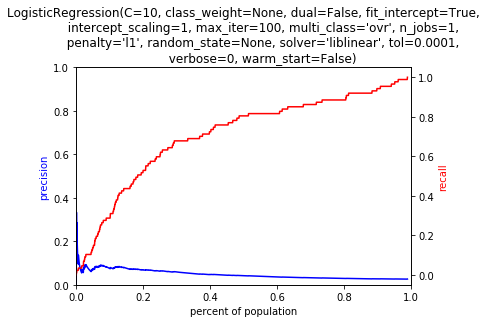

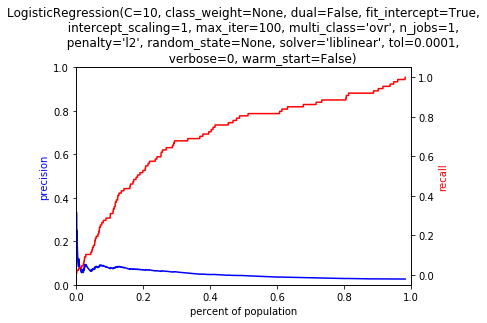

NB 50


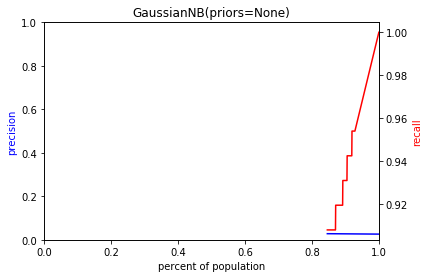

LR 60


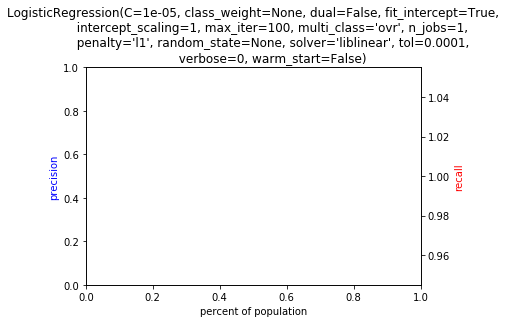

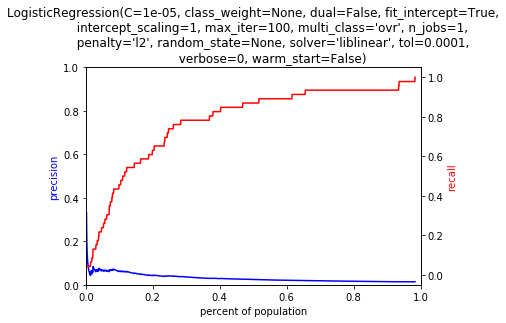

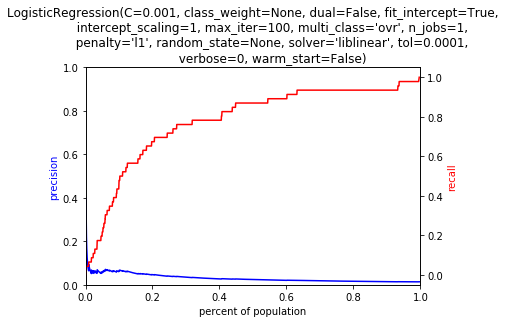

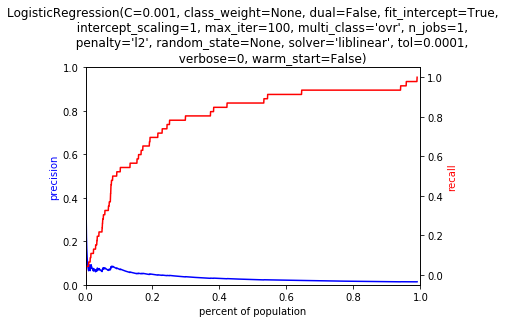

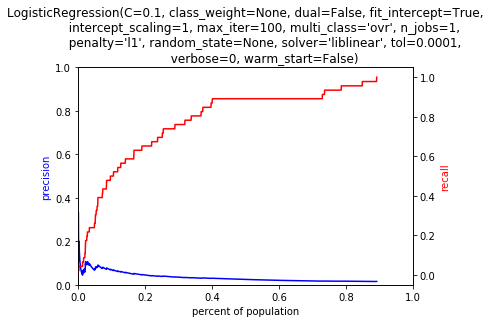

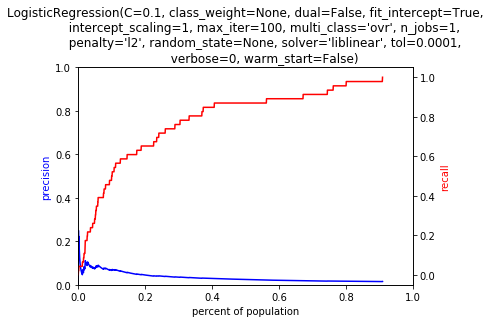

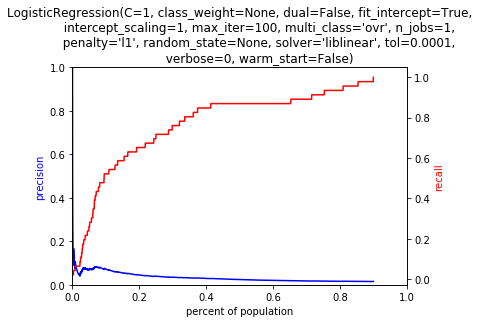

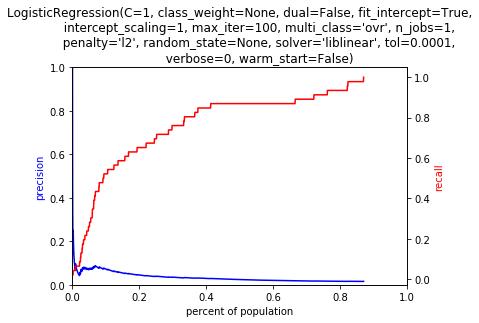

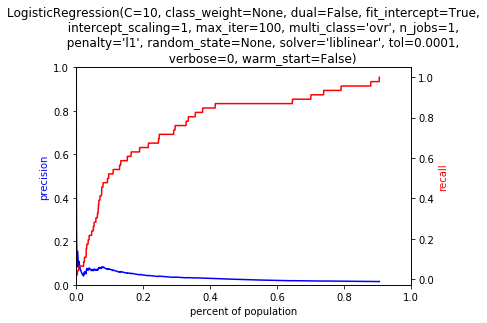

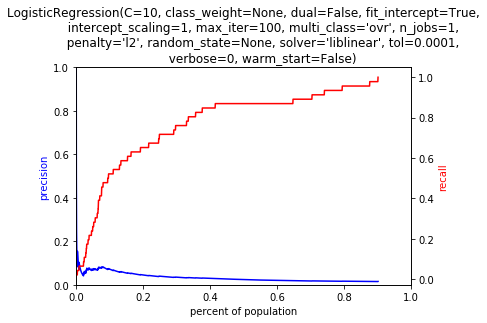

NB 60


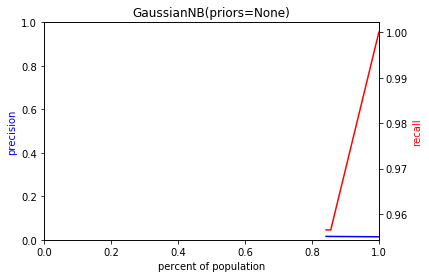

In [24]:
# define grid to use: test, small, large
grid_size = 'small'
clfs, grid = define_clfs_params(grid_size)

# define models to run
models_to_run=['LR', 'NB']

# call clf_loop for balanced data
models = clf_loop(df,models_to_run, clfs, grid, [5,10,20,30,40,50,60])

LR 5


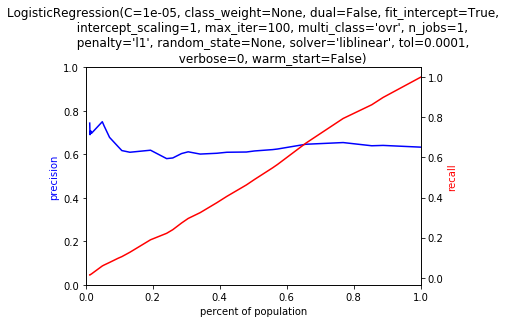

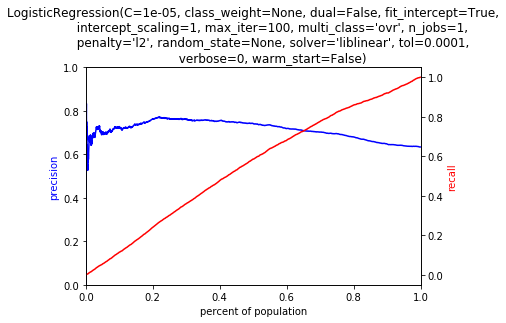

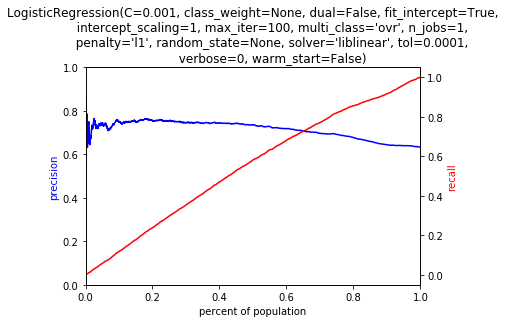

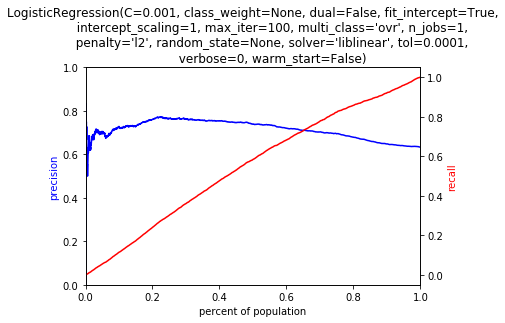

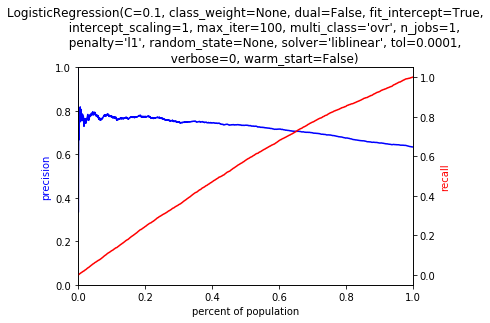

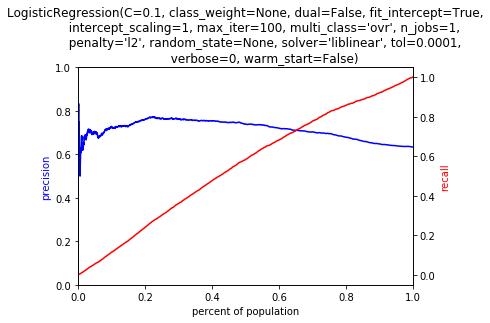

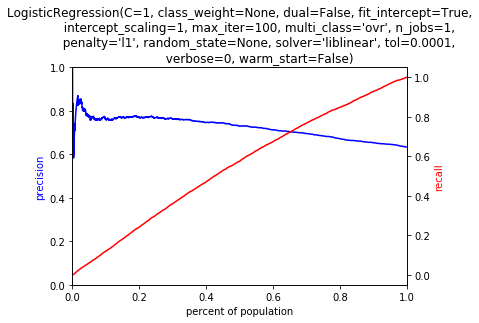

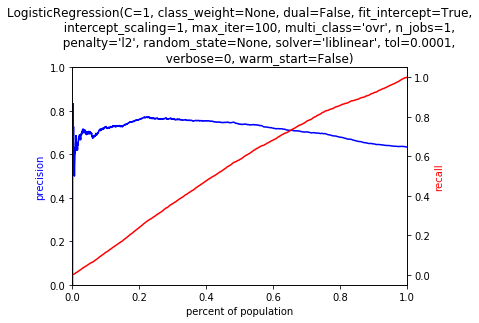

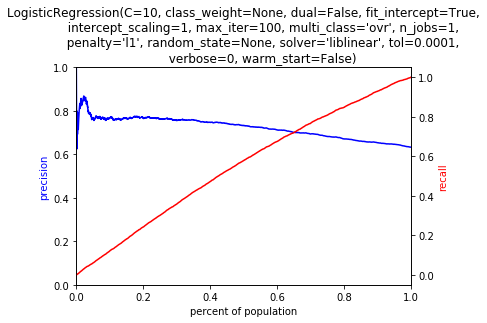

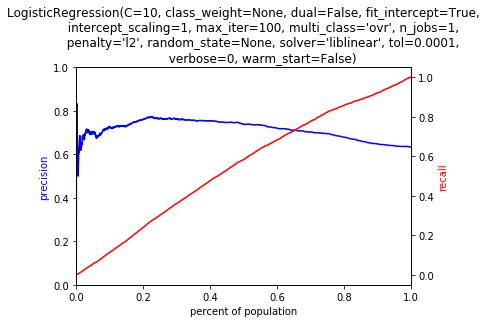

NB 5


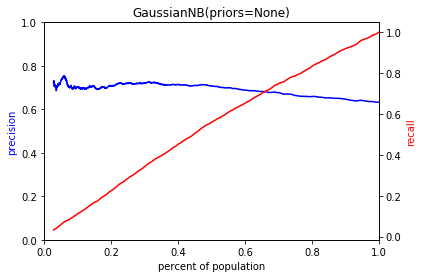

LR 10


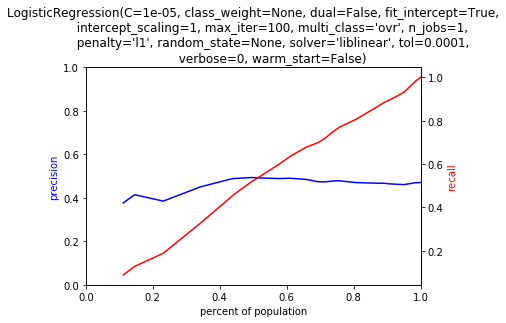

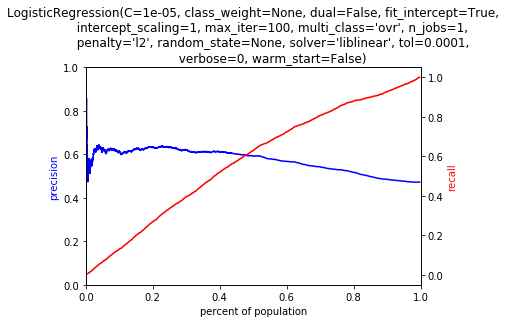

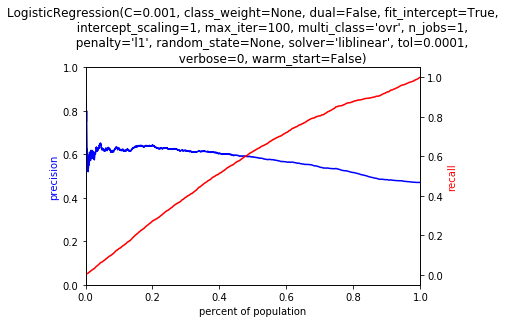

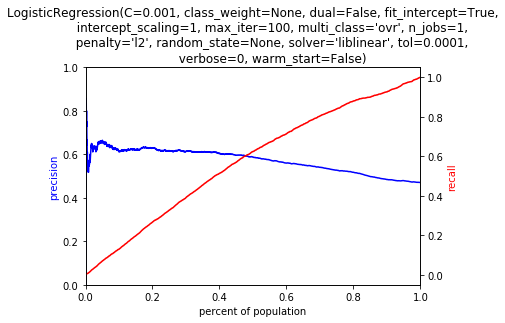

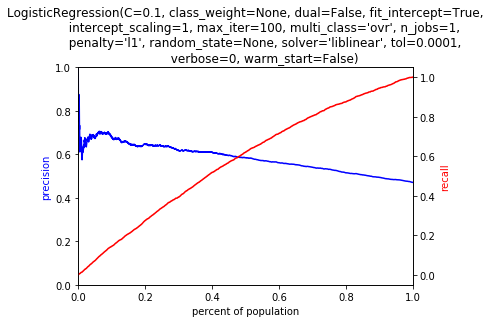

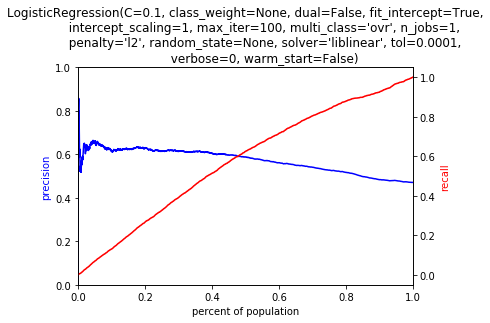

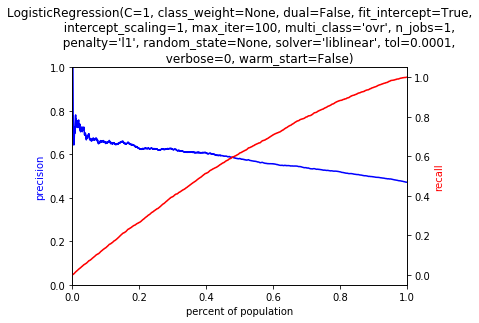

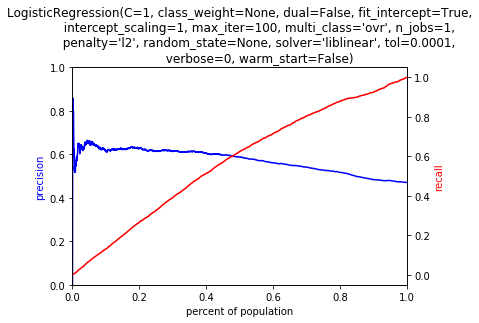

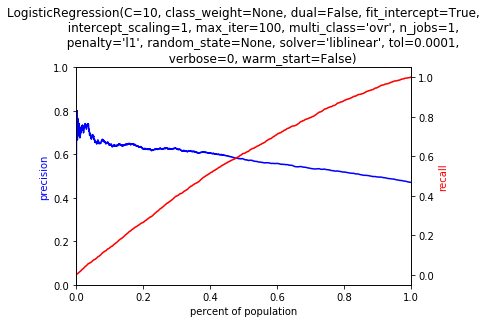

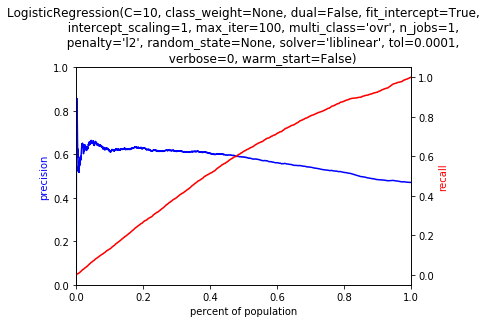

NB 10


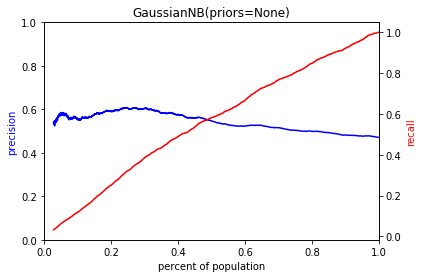

LR 20


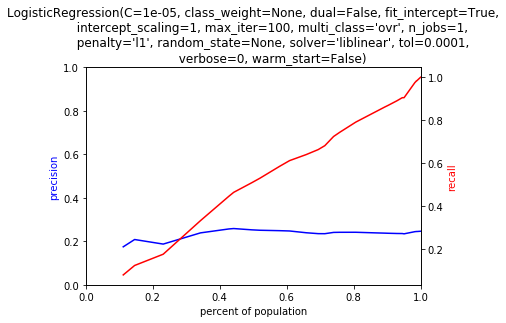

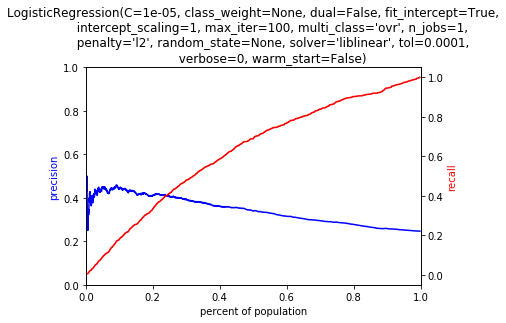

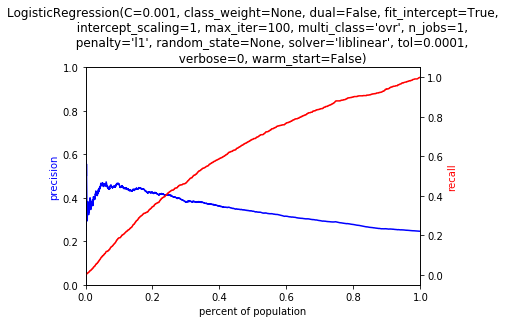

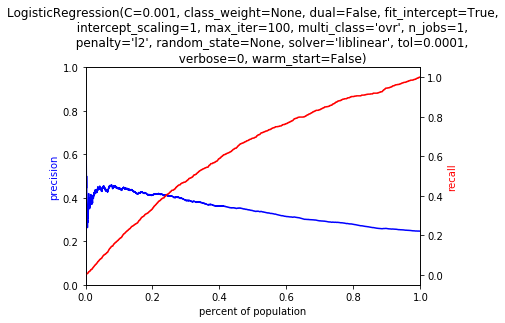

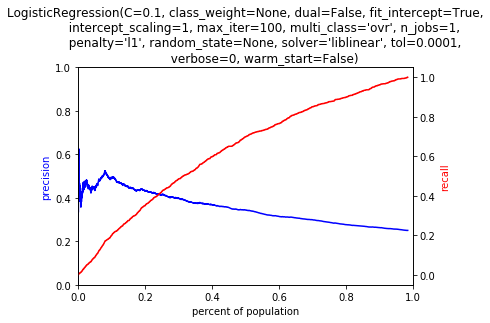

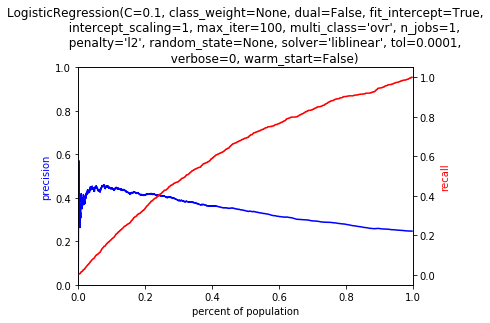

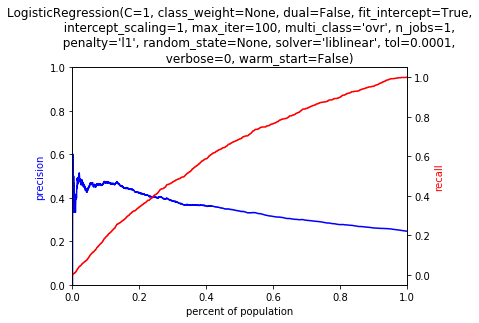

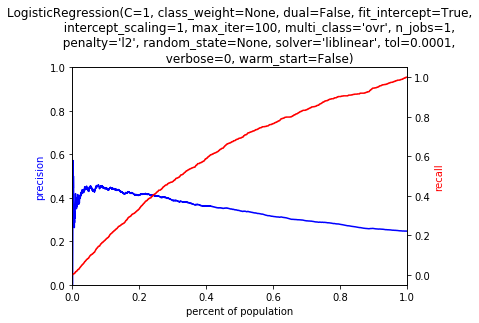

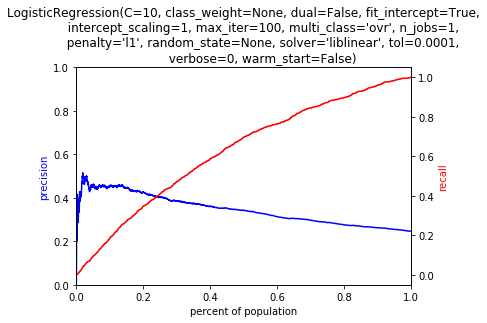

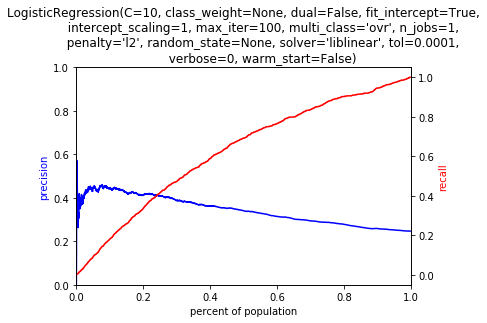

NB 20


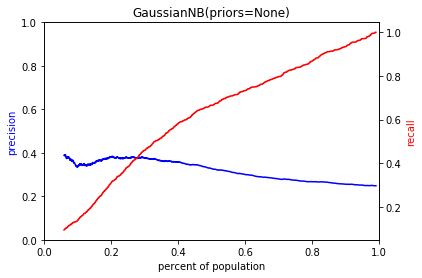

LR 30


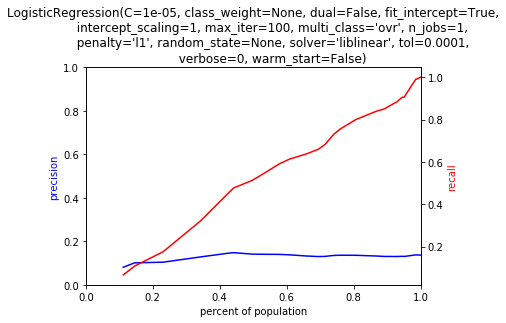

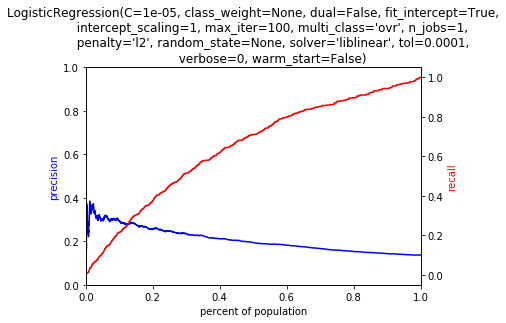

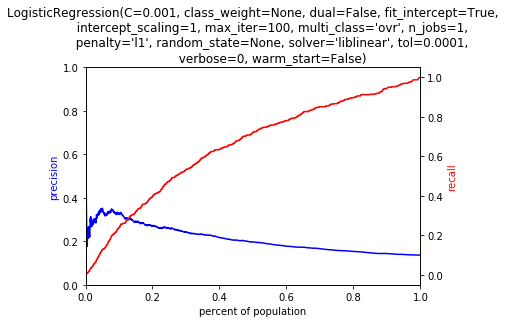

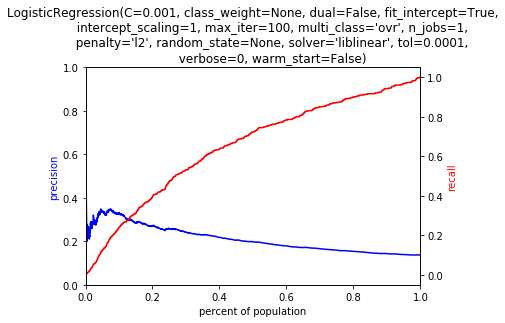

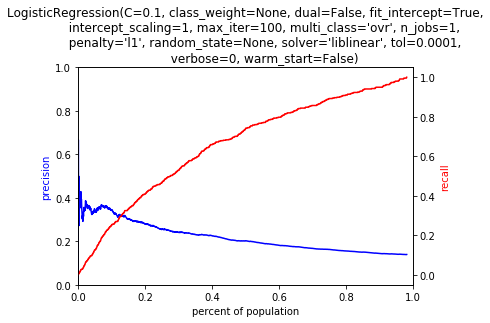

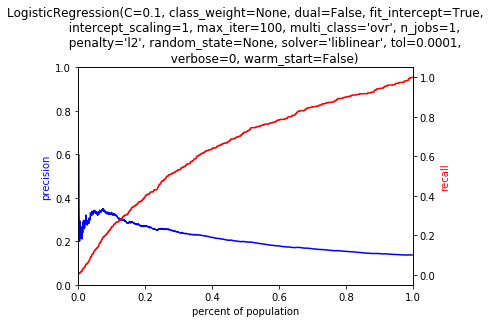

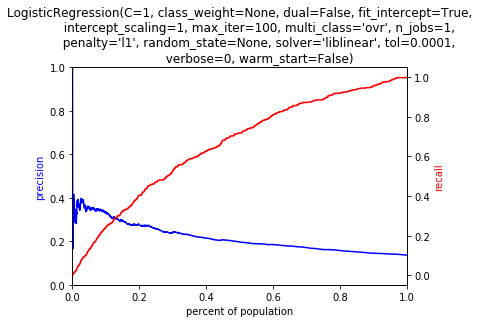

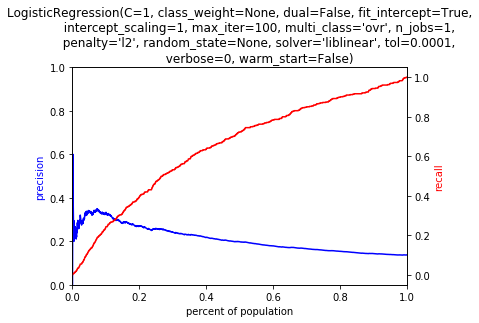

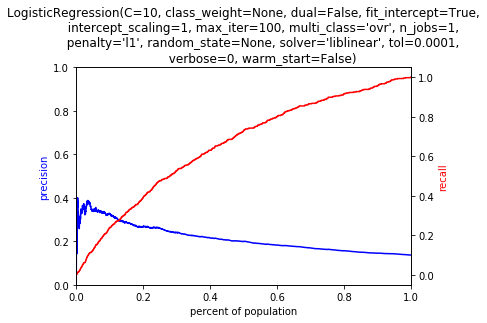

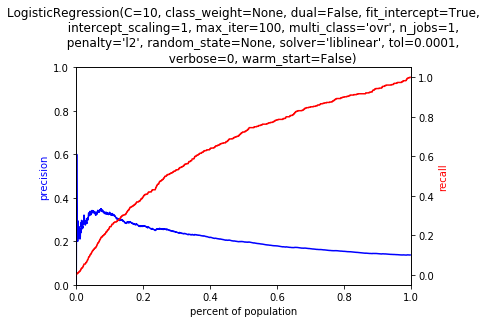

NB 30


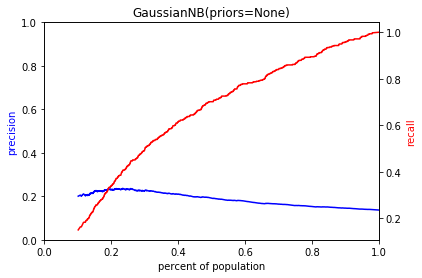

LR 40


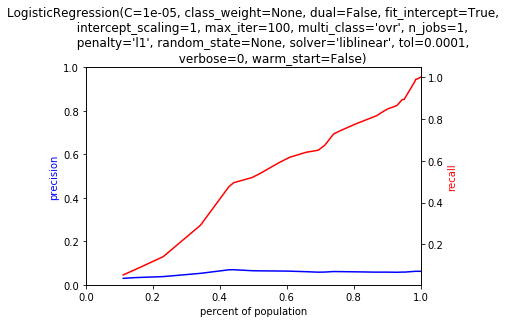

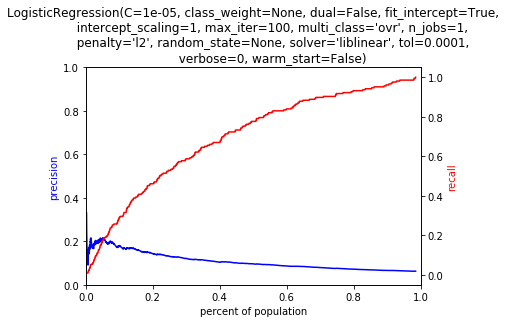

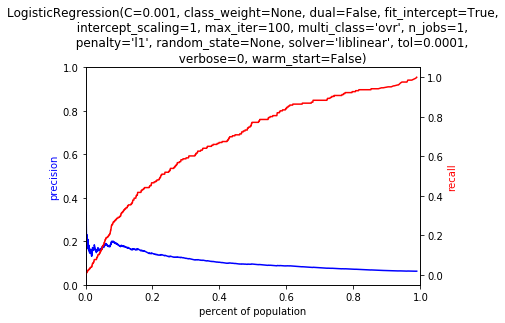

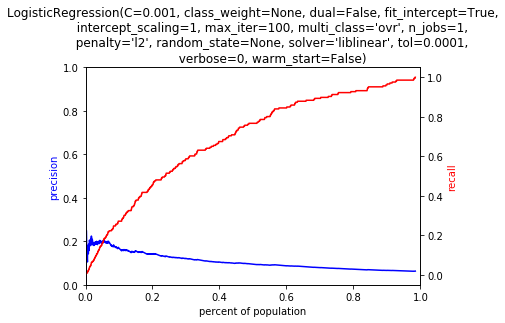

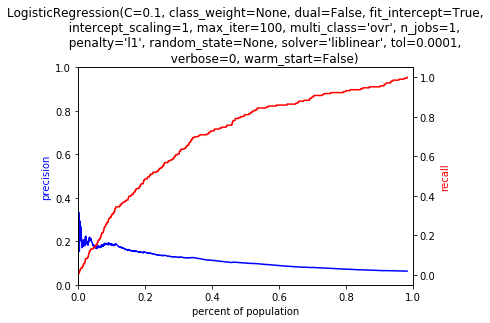

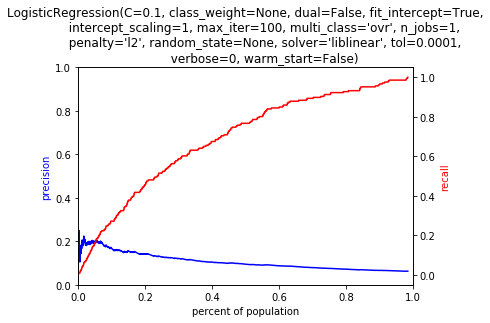

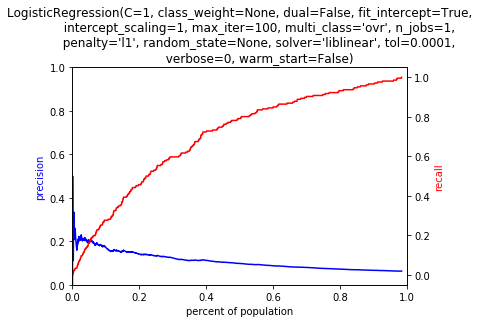

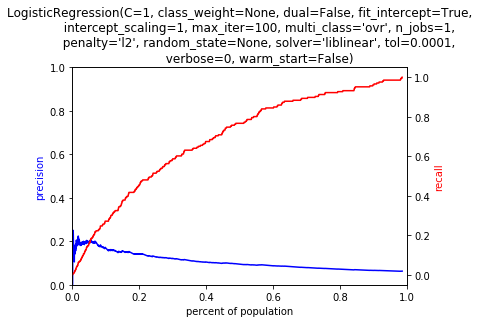

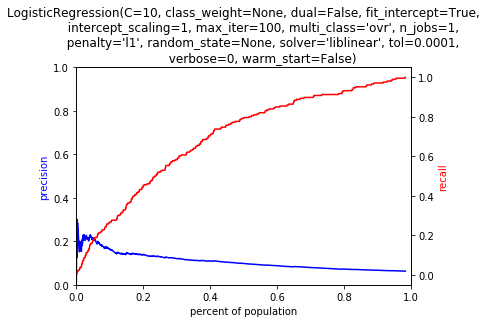

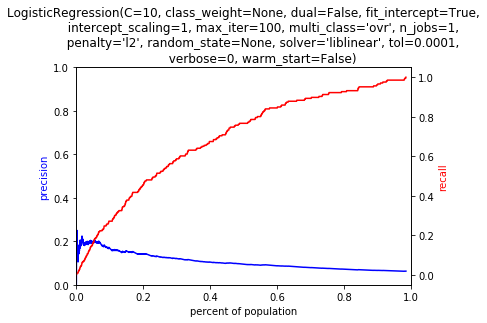

NB 40


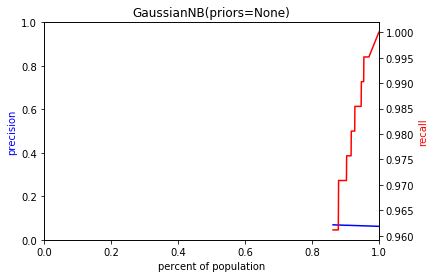

LR 50


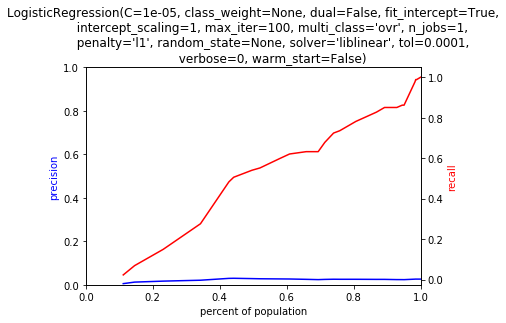

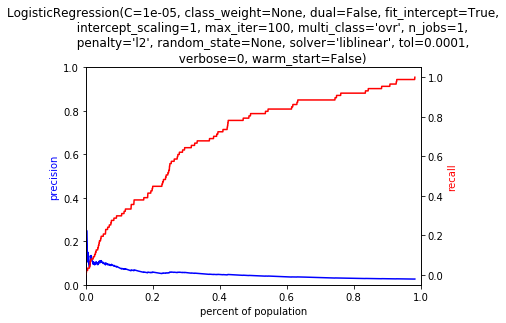

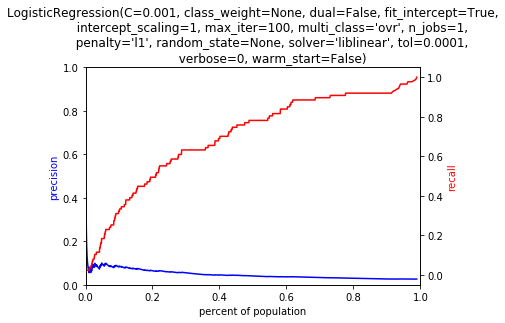

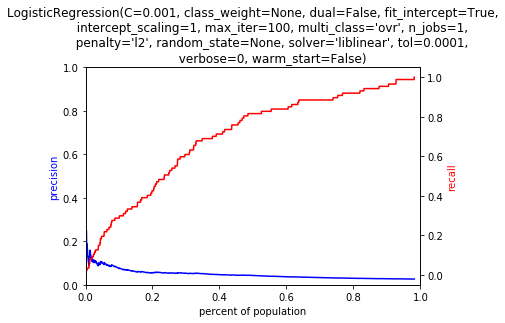

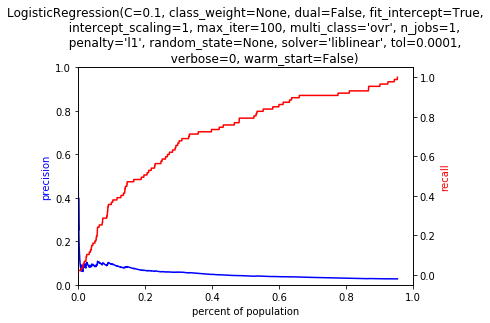

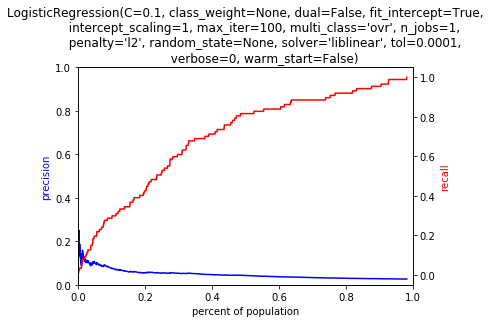

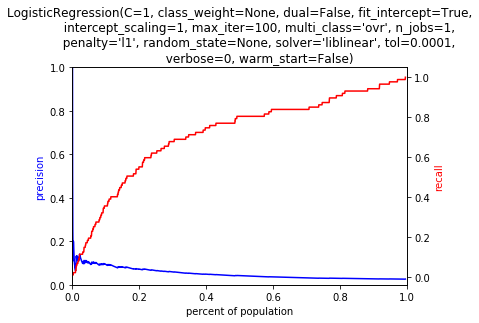

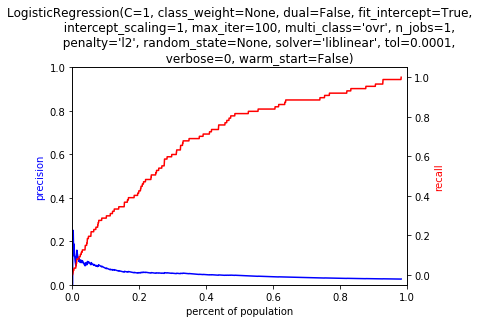

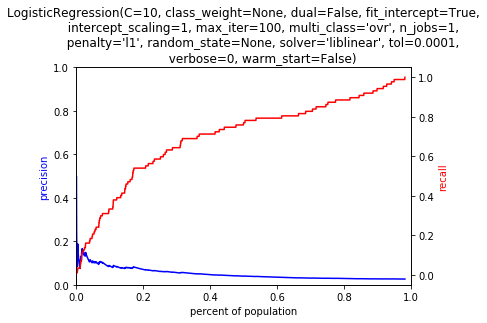

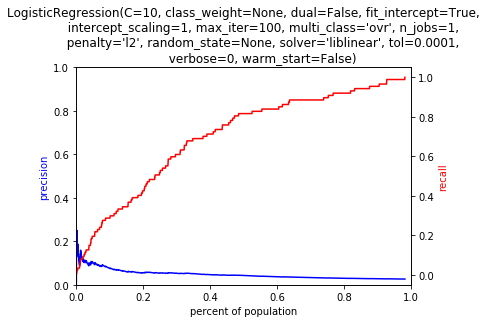

NB 50


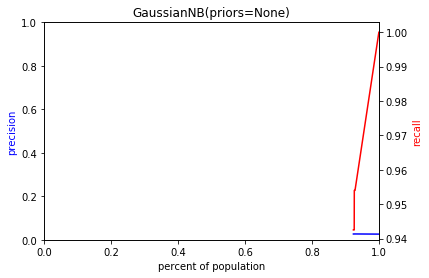

LR 60


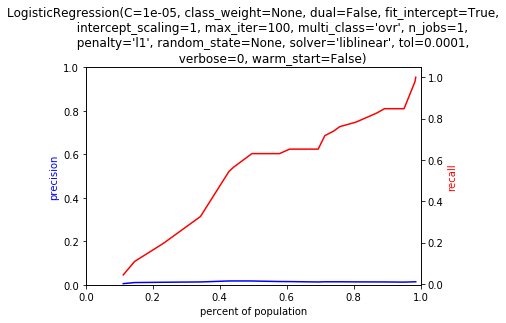

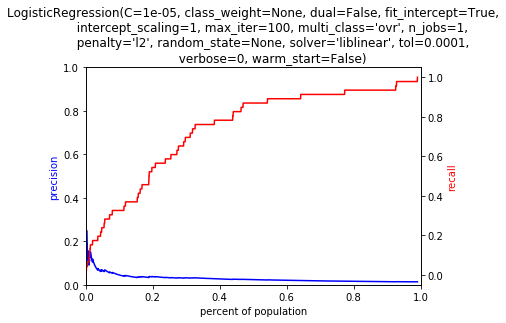

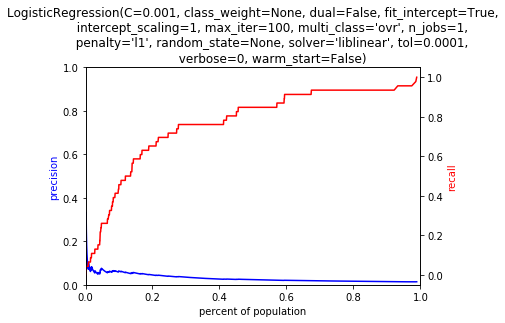

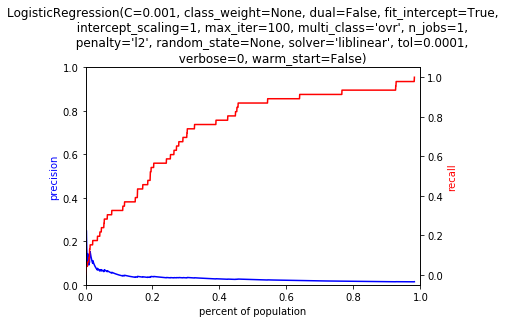

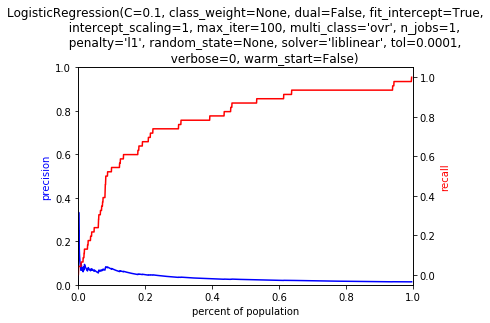

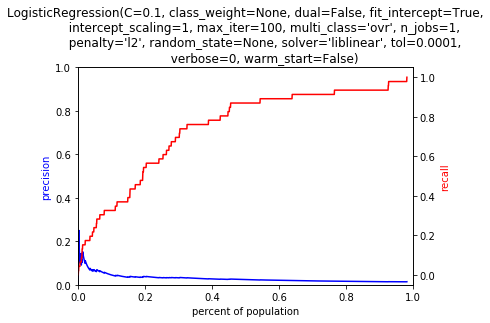

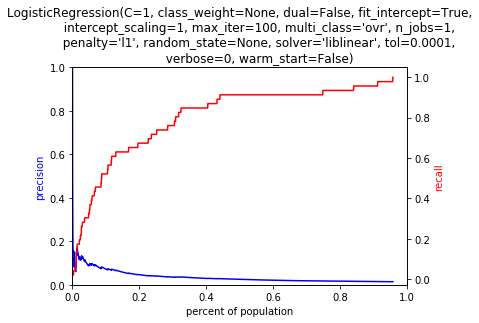

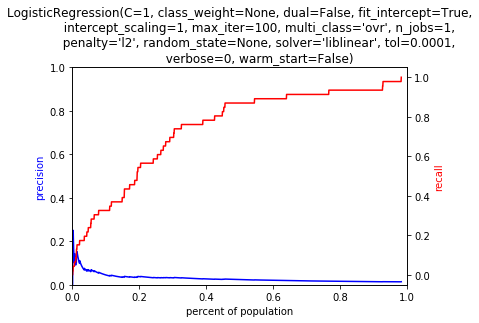

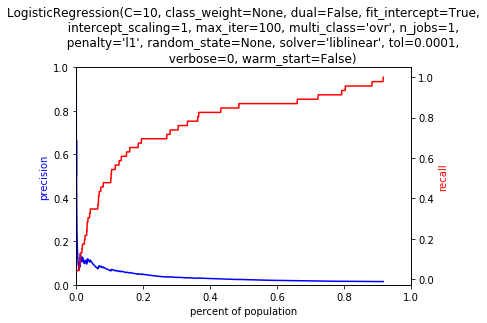

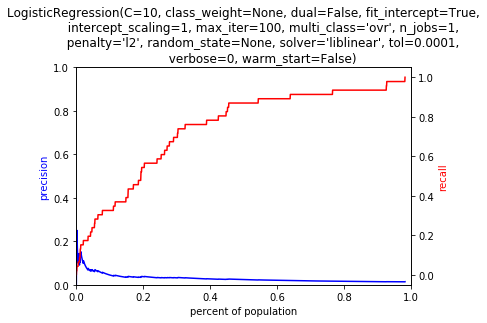

NB 60


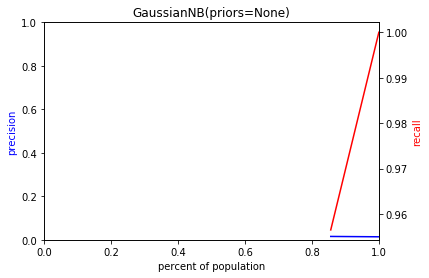

In [26]:
# call clf_loop for balanced data
models_im = clf_loop(df,models_to_run, clfs, grid, [5,10,20,30,40,50,60],balanced=False)